# Data Challenge

## Instructions
You will find a database of a representative sample of search and share events for the month of June for GIF Keyboard (US-only). Please analyze this data, provide written responses to questions 1-4 below, and prepare to discuss the data during the on-site interviews.

**1. "Warmup" metrics:**
    - Compute the aggregate "share rate": Ratio of shares to searches
    - Compute the share rate for the top 1000 most-searched terms
    - How many unique search terms are there? What does the distribution look like (consider the count per search term; plot or describe the results)?
    - How many unique gifs are shared? What does the distribution look like?

**2. Advanced metrics:**
    - A "search session" is defined as a series of consecutive searches by a user, close in temporal proximity (typically on the order of seconds), that may or may not result in a share. Given the available data, how would you compute the average duration of a search session? Bonus: Estimate the average duration of a search session, and compute the ratio of shares to search sessions.

**3. Experimental design (hint: A/B testing):**
    - Suppose you've built a new model for the search engine that you'd like to test against the current model.
        * How would you measure the effectiveness of the new model?
        * What additional data would you need in the dataset to compare the effectiveness of the new vs. current models?
        * How would you determine the statistical significance of the results?

**4. Predictive models:**
    - There is sufficient data in the dataset to build a crude "search suggestions" model: Given a specific search term, return a list of related search terms. Describe how you might build such a model (describe the data you would use, techniques, inferences, etc.; you do not need to implement this).

**5. Insights and discussion points for on-site:**
    - This section is not needed for the written responses. For the on-site interviews, please take another look at the dataset, and be prepared to share and discuss additional insights you can extract from the dataset, or useful models or features you can potentially build from the dataset. Example topics might include semantic analysis of searches, graph analysis of shared GIFs, etc.
    
## Database Info:
    You will have read-write access to the "public" schema. You may create temp tables as necessary. The table with relevant data is "ios_events". The data may be noisy, but we tried to limit the dataset to the most relevant data.

    Notes on relevant columns:
    timestamp - time of user action
    keyboardid - unique anonymous user id
    eventname - textsearch = browse or search; share = share
    tags - primary search term(s)
    riffid - id of the gif shared (gif metadata is not provided)
    tag1/tag2 - may be relevant if autosuggest or filters are used, but this data is noisy
    actions - app behavior triggering the search
    component - sub-component of app
    viewindex - position of the gif shared (or -1 if unknown/unavailable)


In [1]:
import sys
import json
import psycopg2
import pandas as pd
import numpy as np
import pprint
import matplotlib.pyplot as plt
import datetime

In [2]:
def connect_db(config_file):
    with open(config_file) as f:
        config = json.load(f)
    
    connect_str = "host={} port={} dbname={} user={} password={}\
    ".format(config['host'], config['port'], config['database'], config['user'], config['password'])
    
    connection = None
    try:
        connection = psycopg2.connect(connect_str)
        print("Database connected!")
    except:
        print("Unable to connect to the database.")
    
    return connection

In [7]:
conn = connect_db('config.json')

Database connected!


In [ ]:
"""df = pd.DataFrame()
for chunk in pd.read_sql('SELECT * FROM IOS_EVENTS', con = conn, chunksize = 20000):
    df = df.append(chunk)
#df.head(5)
"""

In [53]:
conn.close()

In [9]:
def execute_sql(sql):
    global conn
    if conn.closed:
        conn = connect_db('config.json')
    cursor = conn.cursor()
    cursor.execute(sql)
    rows = cursor.fetchall()
    return rows

In [54]:
sql = 'SELECT * FROM IOS_EVENTS limit 5'
rows = execute_sql(sql) 
for row in rows:
    print(row)

Database connected!
(datetime.datetime(2017, 6, 1, 0, 4, 50), 'MjA0Mzg5MjY', 'textsearch', 'search', 'party', '0', 'iOS_GK_3.5', '', 'iPhone7,1|10.3.1', 'Part', 'en_US', 'party', '', 'autosuggest', 'keyboard', -1)
(datetime.datetime(2017, 6, 1, 0, 30, 33), 'NjA0MjI5OTQ', 'textsearch', 'search', 'Fucking', '0', 'iOS_GK_3.5', '', 'iPhone8,1|10.3.2', '', 'en_US', 'Fucking', '', 'search_cancel', 'keyboard', -1)
(datetime.datetime(2017, 6, 1, 3, 20, 18), 'MjEzNTcwNA', 'textsearch', 'search', 'cocaine', '0', 'iOS_GK_3.5', '', 'iPhone8,1|10.3.2', 'cocaine', 'en_US', 'cocaine', '', 'autosuggest', 'messages', -1)
(datetime.datetime(2017, 6, 1, 3, 42, 24), 'OTg0NTY0NTg', 'textsearch', 'search', 'freshprince', '0', 'iOS_GK_3.5', '', 'iPhone7,2|10.2', 'Fresh', 'en_US', 'freshprince', '', 'autosuggest', 'keyboard', -1)
(datetime.datetime(2017, 6, 1, 5, 43, 39), 'OTg3NTU1NjY', 'textsearch', 'search', 'congratulations', '0', 'iOS_GK_3.5', '', 'iPhone9,4|10.3.2', 'Congr', 'en_US', 'congratulations', '

### Challenge Question - 1

**1. "Warmup" metrics:**
    - Compute the aggregate "share rate": Ratio of shares to searches
    - Compute the share rate for the top 1000 most-searched terms
    - How many unique search terms are there? What does the distribution look like (consider the count per search term; plot or describe the results)?
    - How many unique gifs are shared? What does the distribution look like?

#### Compute the aggregate "share rate": Ratio of shares to searches

In [41]:
share_rate_sql = "SELECT TSHARE*1.0/TSEARCH AS SHARE_RATIO \
    FROM \
        ( \
            SELECT 'TOTAL' AS TOTAL, \
            SUM(CASE WHEN EVENTNAME='textsearch' THEN 1 END) AS TSEARCH, \
            SUM(CASE WHEN EVENTNAME='share' THEN 1 END) AS TSHARE \
                FROM IOS_EVENTS \
                GROUP BY 1 \
        )"
results = execute_sql(share_rate_sql)
print('The ratio of shares to searches is '+str(results[0][0])[0:4] +'.')

The ratio of shares to searches is 0.65.


#### Compute the share rate for the top 1000 most-searched terms

In [58]:
top_1000_searched_terms_sql = "SELECT  \
			AVG(TSHARE * 1.0 / TSEARCH) AS TAGS_SHARE_RATIO \
		FROM \
		( \
			SELECT TAGS AS TAGS, \
				SUM(CASE WHEN EVENTNAME='textsearch' THEN 1 END) AS TSEARCH, \
				SUM(CASE WHEN EVENTNAME='share' THEN 1 END) AS TSHARE  \
			FROM  \
				( \
				SELECT TAGS, EVENTNAME  \
				FROM IOS_EVENTS  \
				WHERE TAGS IN ( SELECT TAGS FROM ( SELECT TAGS, COUNT(*) FROM IOS_EVENTS \
                WHERE TRIM(TAGS) <> '' GROUP BY TAGS ORDER BY 2 DESC LIMIT 1000 )) \
				) \
			GROUP BY 1 ) "
results = execute_sql(top_1000_searched_terms_sql)
print('The ratio of shares to searches on top 1000 most searched terms is '+str(results[0][0])[0:4] +'.')

The ratio of shares to searches on top 1000 most searched terms is 0.74.


#### How many unique search terms are there? What does the distribution look like (consider the count per search term; plot or describe the results)?

In [59]:
number_of_unique_searchterms_sql = "SELECT COUNT(DISTINCT TAGS) FROM IOS_EVENTS"
results = execute_sql(number_of_unique_searchterms_sql)
print('The number of total unique search terms are '+str(results[0][0]) +'.')

The number of total unique search terms are 2729143.


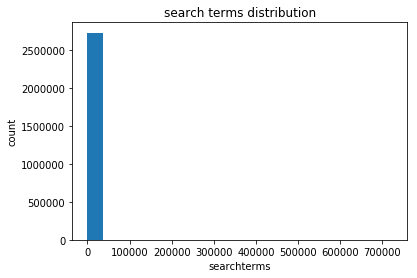

In [17]:
unique_searchterms_sql = "SELECT DISTINCT TAGS, COUNT(*) FROM IOS_EVENTS WHERE TRIM(TAGS) != '' GROUP BY TAGS ORDER BY 2"
results = execute_sql(unique_searchterms_sql)

data = []
for row in results:
    data.append(row[1]) 

plt.hist(data, bins = 20)
plt.xlabel('searchterms')
plt.ylabel('count')
plt.title('search terms distribution')
plt.show()

###### Analysis Description:
*1. Gif for agreement:* Looks like people would want to use gifs to say yes or agree to something.
*2. Gif for happy birthday:* people would want to use gif for occations like happy birthday and to say good night and all.   

#### How many unique gifs are shared? What does the distribution look like?

In [61]:
number_of_unique_gifs_shared_sql = "SELECT COUNT(DISTINCT RIFFID) FROM IOS_EVENTS"
results = execute_sql(number_of_unique_searchterms_sql)
print('The number of total unique gifs shared '+str(results[0][0]) +'.')

The number of total unique gifs shared2729143.


[('7513882', 69662),
 ('7212866', 57450),
 ('5488810', 52495),
 ('5795910', 46818),
 ('5663730', 43491),
 ('5943705', 42212),
 ('4790020', 42092),
 ('3850980', 41186),
 ('4988274', 40465),
 ('5751664', 40172)]


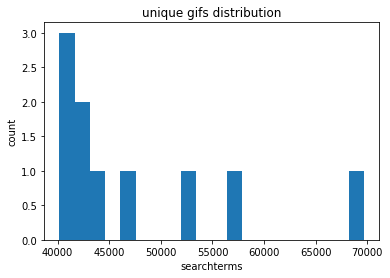

In [20]:
unique_gifs_shared_sql = "SELECT RIFFID, COUNT(*) FROM IOS_EVENTS WHERE RIFFID != 0 GROUP BY RIFFID ORDER BY 2 DESC LIMIT 10"
results = execute_sql(unique_gifs_shared_sql)
pprint.pprint(results[0:1000])

data = []
for row in results:
    data.append(row[1]) 

plt.hist(data, bins = 20)
plt.xlabel('searchterms')
plt.ylabel('count')
plt.title('unique gifs distribution')
plt.show()

#### 2. Advanced metrics:
A "search session" is defined as a series of consecutive searches by a user, close in temporal proximity (typically on the order of seconds), that may or may not result in a share. Given the available data, how would you compute the average duration of a search session? Bonus: Estimate the average duration of a search session, and compute the ratio of shares to search sessions.

###### Average Duration of Search session

In [27]:
search_session_sql = "SELECT KEYBOARDID, COUNT(*) AS TOTAL_NUMBER_OF_SEARCHES, \
        SUM(extract(epoch from duration)) AS TOTAL_SEARCH_DURATION, \
        AVG(extract(epoch from duration)) AS AVERAGE_SEARCH_DURATION \
    FROM \
        (SELECT KEYBOARDID, \
            TIMESTAMP AS T, \
            (TIMESTAMP - LAG(TIMESTAMP) OVER (PARTITION BY KEYBOARDID ORDER BY KEYBOARDID, TIMESTAMP))*1.0 AS DURATION \
            FROM IOS_EVENTS WHERE EVENTNAME = 'textsearch' \
        ) GROUP BY KEYBOARDID LIMIT 10"

('MTA0MDA0Mjc0', 17, 1990390.0, 124399.375)
('MTA0MDA0NTEx', 56, 2509166.0, 45621.2)
('MTA0MDA0NjU1', 2, 8.0, 8.0)
('MTA0MDA1MzAw', 1, None, None)
('MTA0MDA1NzEx', 1, None, None)
('MTA0MDA1Nzg1', 2, 389.0, 389.0)
('MTA0MDA2MDg0', 125, 2511861.0, 20256.9435483871)
('MTA0MDA2MjUz', 1, None, None)
('MTA0MDA2NjE5', 9, 1299906.0, 162488.25)
('MTA0MDA3MjE3', 9, 1722138.0, 215267.25)


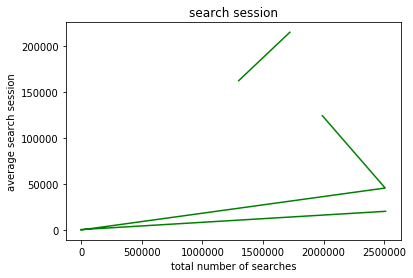

In [29]:
x = []
y = []
for row in execute_sql(search_session_sql):
    print(row)
    x.append(row[2])
    y.append(row[3])
    
plt.plot(x, y, 'g')
plt.xlabel('total number of searches')
plt.ylabel('average search session')
plt.title('search session')
plt.show()   

###### Ratio of Shares to Searches

#### 3. Experimental design (hint: A/B testing):

- Suppose you've built a new model for the search engine that you'd like to test against the current model.
    * How would you measure the effectiveness of the new model?
    * What additional data would you need in the dataset to compare the effectiveness of the new vs. current models?
    * How would you determine the statistical significance of the results?

*How would you measure the effectiveness of the new model?*

ANSWER: By testing the new model against test set. The error rate shoud be very less. The less error rate, more effectiveness of the new model 

*What additional data would you need in the dataset to compare the effectiveness of the new vs. current models?*

ANSWER: Maybe the input entries by the user as the TAGS currently has fully typed words. 

*How would you determine the statistical significance of the results?*

ANSWER: Test valdiation should have less error.

#### 4. Predictive models:

- There is sufficient data in the dataset to build a crude "search suggestions" model: Given a specific search term, return a list of related search terms. Describe how you might build such a model (describe the data you would use, techniques, inferences, etc.; you do not need to implement this).

In [63]:
def get_related_search_terms(search_term):
    related_search_terms_sql = "SELECT TAGS FROM (\
    SELECT TAGS, COUNT(*) FROM IOS_EVENTS WHERE TAGS LIKE '" + search_term + "%' \
    GROUP BY TAGS ORDER BY 2 DESC LIMIT 10 )"
    results = execute_sql(related_search_terms_sql)
    for row in results:
        print(row[0])

In [64]:
get_related_search_terms('happ')

happybirthday
happy
happy birthday
happy fathers day
happy dance
happydance
happyanniversary
happy Birthday
happyfriday
happygilmore


##### Predictive Model Description:

We can probably use TD-IDF (term frequency–inverse document frequency) approach using tags and tag1 features. This will give the important words used in the search terms.

#### 5. Insights and discussion points for on-site:

- This section is not needed for the written responses. For the on-site interviews, please take another look at the dataset, and be prepared to share and discuss additional insights you can extract from the dataset, or useful models or features you can potentially build from the dataset. Example topics might include semantic analysis of searches, graph analysis of shared GIFs, etc.

##### Below are some of the example graphs and insights from the data

happy birthday search term usage

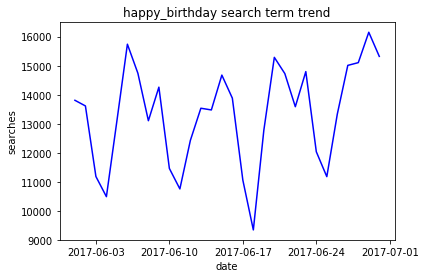

In [31]:
happy_birthday_sql = "SELECT TIMESTAMP::DATE , count(*) FROM IOS_EVENTS \
                    WHERE TAGS = 'happybirthday' GROUP BY TIMESTAMP::DATE ORDER BY 1"
x = []
y = []
for row in execute_sql(happy_birthday_sql):
    x.append(row[0])
    y.append(row[1])
plt.plot(x, y, 'b')
plt.xlabel('date')
plt.ylabel('searches')
plt.title('happy_birthday search term trend')
plt.show()

top user search activity

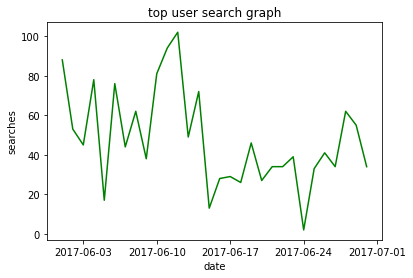

In [32]:
top_user_sql = "SELECT TIMESTAMP::Date, COUNT(*) FROM IOS_EVENTS WHERE EVENTNAME = 'textsearch' \
AND KEYBOARDID = 'MTA0NTA4MzU2' GROUP BY TIMESTAMP::Date ORDER BY 1"
x = []
y = []
for row in execute_sql(top_user_sql):
    x.append(row[0])
    y.append(row[1])
    
plt.plot(x, y, 'g')
plt.xlabel('date')
plt.ylabel('searches')
plt.title('top user search graph')
plt.show()   

top gif shared trending graph

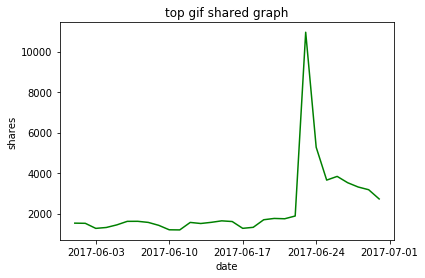

In [33]:
top_gif_shared_sql = "SELECT TIMESTAMP::DATE, COUNT(*) FROM IOS_EVENTS \
WHERE RIFFID = '7513882' GROUP BY TIMESTAMP::DATE ORDER BY 1"
x = []
y = []
for row in execute_sql(top_gif_shared_sql):
    x.append(row[0])
    y.append(row[1])
    
plt.plot(x, y, 'g')
plt.xlabel('date')
plt.ylabel('shares')
plt.title('top gif shared graph')
plt.show() 

top trending gifs recently

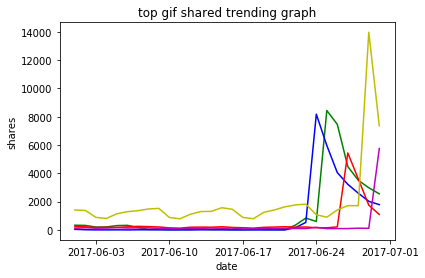

In [34]:
top_trending_gifs_sql = \
"SELECT TIMESTAMP::DATE, RIFFID, COUNT(*) FROM IOS_EVENTS WHERE RIFFID IN ( \
SELECT RIFFID FROM \
( \
	SELECT RIFFID, _DATETIME, COUNT, (_DATETIME - LAG(_DATETIME) OVER (PARTITION BY RIFFID ORDER BY _DATETIME)) AS _INTERVAL, \
	(COUNT - LAG(COUNT) OVER (PARTITION BY RIFFID ORDER BY _DATETIME )) AS SHARE_DIFF \
	FROM \
	(SELECT RIFFID, TIMESTAMP::DATE AS _DATETIME, COUNT(*) AS COUNT FROM IOS_EVENTS WHERE EVENTNAME = 'share' AND RIFFID != 0 GROUP BY RIFFID, TIMESTAMP::DATE) \
) \
WHERE SHARE_DIFF IS NOT NULL AND SHARE_DIFF > 2000 AND _DATETIME > '2017-06-23'::Date \
ORDER BY SHARE_DIFF DESC LIMIT 5 ) GROUP BY TIMESTAMP::DATE, RIFFID ORDER BY TIMESTAMP::DATE"
x1 = []
x2 = []
x3 = []
x4 = []
x5 = []

y1 = []
y2 = []
y3 = []
y4 = []
y5 = []

riffids = []
for row in execute_sql(top_trending_gifs_sql):
    if row[1] not in riffids:
        riffids.append(row[1])

for row in execute_sql(top_trending_gifs_sql):
    if riffids[0] == row[1]:
        x1.append(row[0])
        y1.append(row[2])
    if riffids[1] == row[1]:
        x2.append(row[0])
        y2.append(row[2])
    if riffids[2] == row[1]:
        x3.append(row[0])
        y3.append(row[2])
    if riffids[3] == row[1]:
        x4.append(row[0])
        y4.append(row[2])
    if riffids[4] == row[1]:
        x5.append(row[0])
        y5.append(row[2])
    
plt.plot(x1, y1, 'g')
plt.plot(x2, y2, 'b')
plt.plot(x3, y3, 'r')
plt.plot(x4, y4, 'y')
plt.plot(x5, y5, 'm')

plt.xlabel('date')
plt.ylabel('shares')
plt.title('top gif shared trending graph')
plt.show() 

In [ ]:
conn.close()